## Check for phase connection

This notebook is meant to answer a common type of question: when I have a solution for a pulsar that goes from ${\rm MJD}_1$ to ${\rm MJD}_2$, can I confidently phase connect it to other data starting at ${\rm MJD}_3$?  What is the phase uncertainty bridging the gap from $\Delta t={\rm MJD}_3-{\rm MJD}_2$?

This notebook will start with standard pulsar timing.  It will then use the `simulation/calculate_random_models` function to propagate the phase uncertainties forward and examine what happens.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import pint.fitter, pint.toa, pint.simulation
from pint.models import get_model_and_toas
from pint import simulation
import pint.config
import pint.logging

# setup logging
pint.logging.setup(level="INFO")

1

In [2]:
# use the same data as `time_a_pulsar` notebook
parfile = pint.config.examplefile("NGC6440E.par")
timfile = pint.config.examplefile("NGC6440E.tim")

In [3]:
# we will do this very simply - ignoring some of the TOA filtering
m, t = get_model_and_toas(parfile, timfile)
f = pint.fitter.WLSFitter(t, m)
f.fit_toas()

59.57471349427808678

In [4]:
print("Current free parameters: ", f.model.free_params)

Current free parameters:  ['RAJ', 'DECJ', 'F0', 'F1', 'DM']


In [5]:
print(f"Current last TOA: MJD {f.model.FINISH.quantity}")

Current last TOA: MJD 54187.58732417023


In [6]:
# pretend we have new observations starting at MJD 59000
# we don't need to track things continuously over that gap, but it helps us visualize what's happening
# so make fake TOAs to cover the gap
MJDmax = 59000
# the number of TOAs is arbitrary since it's mostly for visualization
tnew = pint.simulation.make_fake_toas_uniform(f.model.FINISH.value, MJDmax, 50, f.model)

In [7]:
# make fake models crossing from the last existing TOA to the start of new observations
dphase, mrand = simulation.calculate_random_models(f, tnew, Nmodels=100)
# this is the difference in time across the gap
dt = tnew.get_mjds() - f.model.PEPOCH.value * u.d

Compare against an analytic prediction which focused on the uncertainties from $F_0$ and $F_1 = \dot F$:
$$
\Delta \phi^2 = (\sigma_{F0} \Delta t)^2 + (0.5 \sigma_{F1} \Delta t^2)^2
$$
where $\Delta t$ is the gap over which we are extrapolating the solution.

In [8]:
analytic = np.sqrt(
    (f.model.F0.uncertainty * dt) ** 2 + (0.5 * f.model.F1.uncertainty * dt**2) ** 2
).decompose()

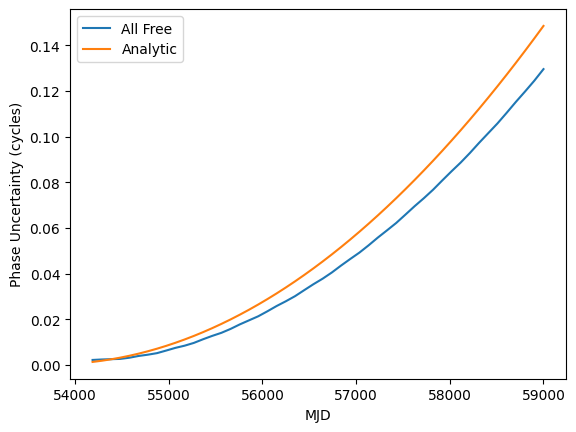

In [9]:
plt.plot(tnew.get_mjds(), dphase.std(axis=0), label="All Free")
tnew.get_mjds() - f.model.PEPOCH.value * u.d
plt.plot(tnew.get_mjds(), analytic, label="Analytic")
plt.xlabel("MJD")
plt.ylabel("Phase Uncertainty (cycles)")
plt.legend()

You can see that the max uncertainty is about 0.14 cycles.  So that means that even at $3\sigma$ confidence, we can be sure that we will have $<1$ cycle uncertainty in extrapolating from the end of the existing solution to MJD 59000.  The analytic solution has the same shape as the numerical solution although it is slightly lower, which makes sense since the analytic solution ignores the covariance between $F_0$ and $F_1$, plus uncertainties on the other free parameters ($\alpha$, $\delta$, ${\rm DM}$).